# Gather DataFrames from CSVs

In [166]:
import pandas as pd

google = pd.read_csv('data/Alphabet_Google.csv')
apple = pd.read_csv('data/Apple.csv')
meta = pd.read_csv('data/Meta Platforms.csv')
microsoft = pd.read_csv('data/Microsoft.csv')
nvidia = pd.read_csv('data/NVIDIA.csv')

# Preprocess the Data

In [167]:
def preprocess_data(company):
    company = company.reset_index()
    company['Date'] = pd.to_datetime(company['Date'])
    company.set_index('Date', inplace=True)
    company = company['Close'].to_frame()

    return company

In [168]:
companies = {}
companies['Google'] = {'data': preprocess_data(google)}
companies['Apple'] = {'data': preprocess_data(apple)}
companies['Meta'] = {'data': preprocess_data(meta)}
companies['Microsoft'] = {'data': preprocess_data(microsoft)}
companies['NVIDIA'] = {'data': preprocess_data(nvidia)}

/var/folders/w2/vspf2xks0vj7x2vwsrfjnszh0000gp/T/ipykernel_94684/2491828488.py:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  company['Date'] = pd.to_datetime(company['Date'])
/var/folders/w2/vspf2xks0vj7x2vwsrfjnszh0000gp/T/ipykernel_94684/2491828488.py:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  company['Date'] = pd.to_datetime(company['Date'])
/var/folders/w2/vspf2xks0vj7x2vwsrfjnszh0000gp/T/ipykernel_94684/2491828488.py:3: FutureWarn

# Build the ARIMA Models for each Company

In [169]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt

def arima_forecast(history):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit() 
    output = model_fit.forecast()
    yhat = output[0]
    return yhat #return predictions

def plot_predictions(name, dates, size, test, predictions):
    plt.plot(dates, test, label='Real')
    plt.plot(dates, predictions, color='red', label='Predicted')
    plt.title(name + ' ARIMA Predictions vs Actual Values')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

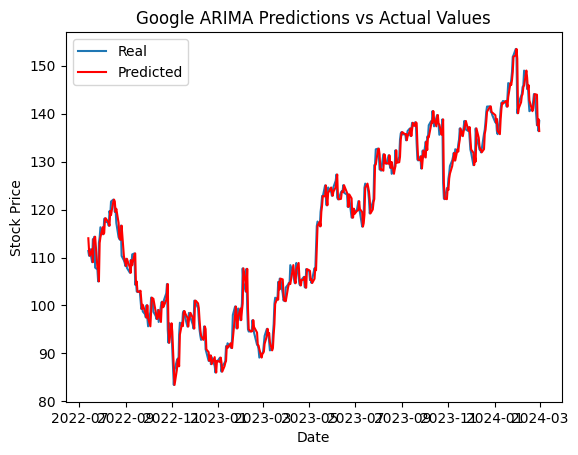

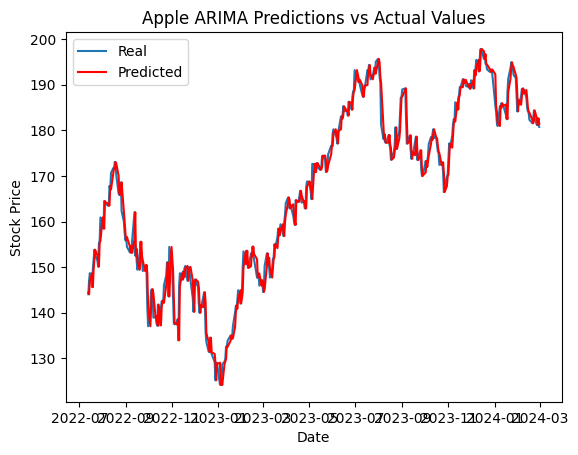

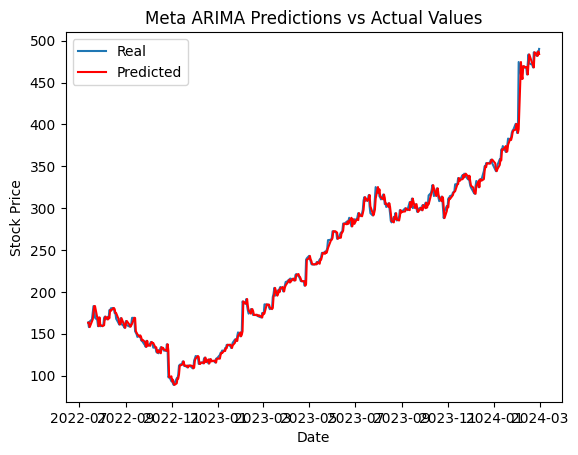

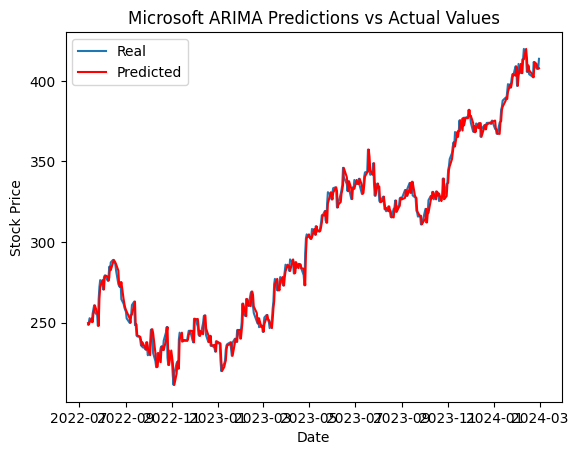

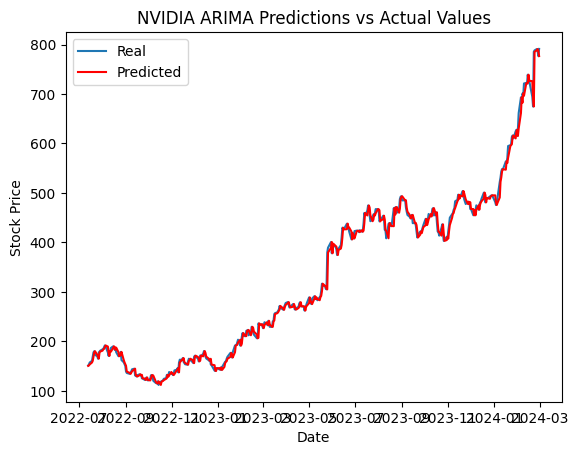

In [170]:
companies_history = {}

#create train and test set
for name, company in companies.items():
    X = company['data'].values
    #sklearn does have a train_test_split function, but we want to do it sequentially to save indices for graphing
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:len(X)]    

    history = [x for x in train]
    predictions = list()

    for i in range(len(test)):
        yhat = arima_forecast(history)
        predictions.append(yhat)
        obs = test[i]
        history.append(obs)

    companies_history[name] = {'history': history}
    plot_predictions(name, company['data'].iloc[train_size:,:].index, train_size, test, predictions)

# Looks pretty accurate with historical data, let's see how it performs with future predictions

In [176]:
from pmdarima.arima import auto_arima

def future_forecast(history, months):
    model = auto_arima(history)
    #model_fit = model.fit() 
    #output = model_fit.forecast(steps = months)
    output = model.predict(n_periods = months)
    return output #return predictions

def plot_future_forecast(name, months, predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(months, predictions, color='red', label='Future Predictions')
    plt.title(name + ' Future Stock Price Predictions using ARIMA')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Identify the best hyperparameters using Auto ARIMA

/var/folders/w2/vspf2xks0vj7x2vwsrfjnszh0000gp/T/ipykernel_94684/1675810447.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_months= pd.date_range(start=companies[name]['data'].index[-1], periods=months+1, freq='M')[1:]


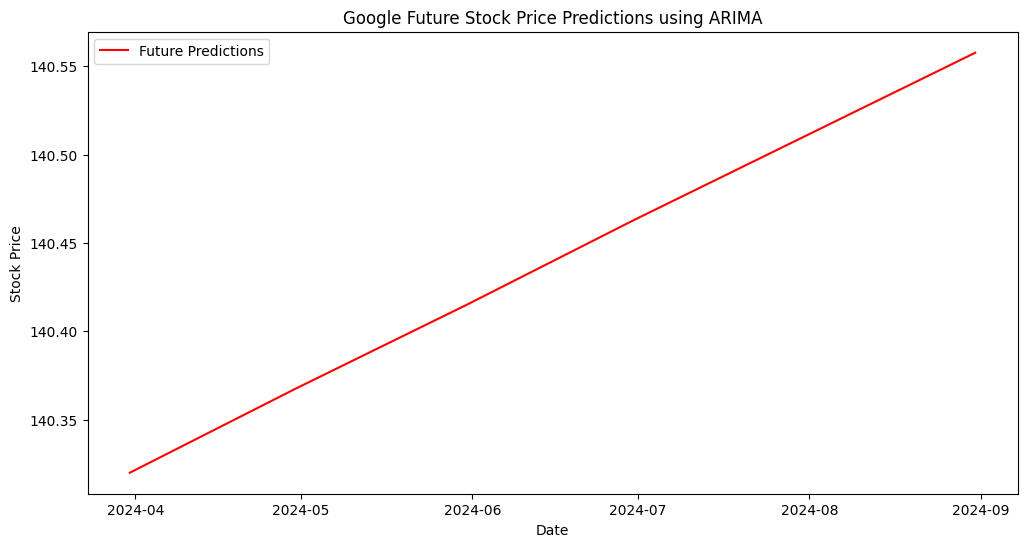

/var/folders/w2/vspf2xks0vj7x2vwsrfjnszh0000gp/T/ipykernel_94684/1675810447.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_months= pd.date_range(start=companies[name]['data'].index[-1], periods=months+1, freq='M')[1:]


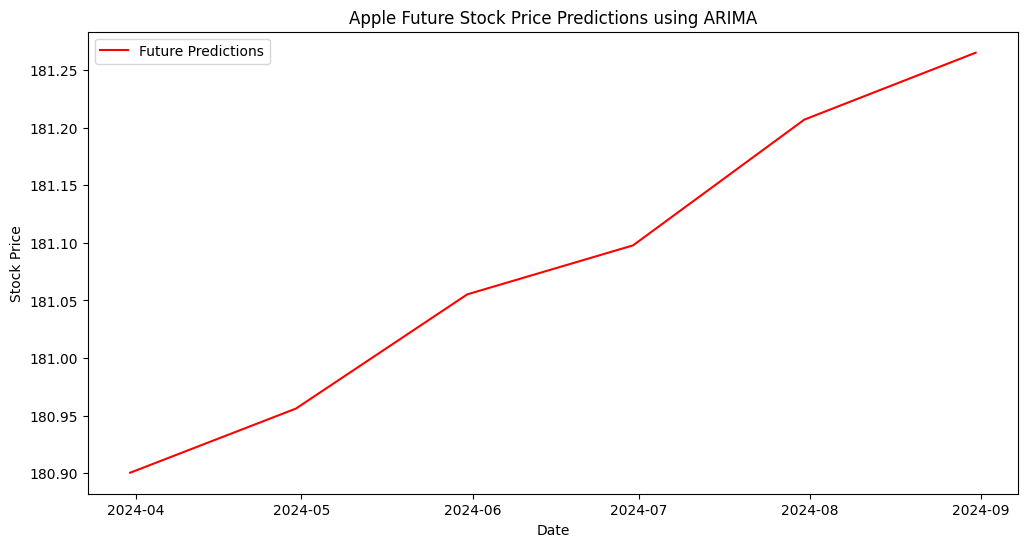

/var/folders/w2/vspf2xks0vj7x2vwsrfjnszh0000gp/T/ipykernel_94684/1675810447.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_months= pd.date_range(start=companies[name]['data'].index[-1], periods=months+1, freq='M')[1:]


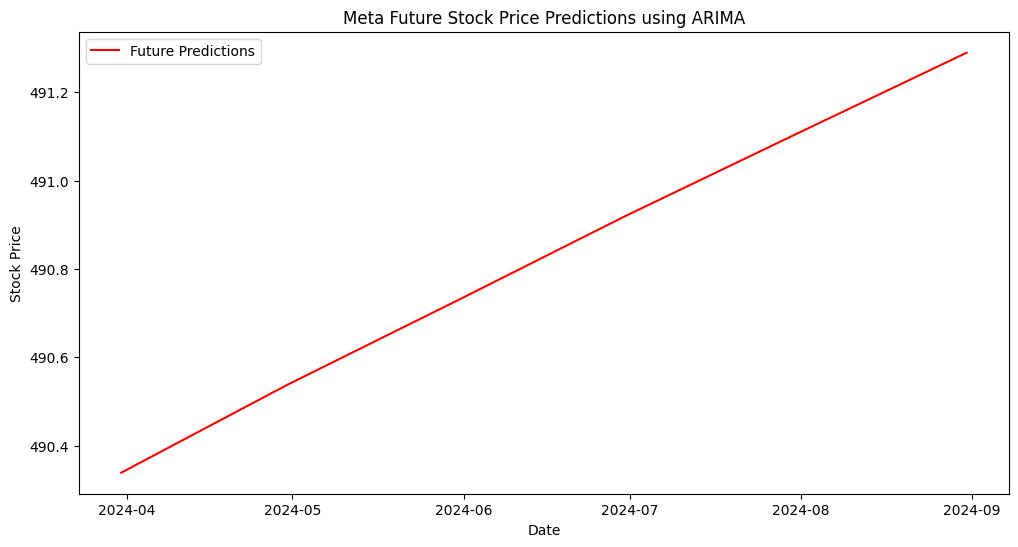

/var/folders/w2/vspf2xks0vj7x2vwsrfjnszh0000gp/T/ipykernel_94684/1675810447.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_months= pd.date_range(start=companies[name]['data'].index[-1], periods=months+1, freq='M')[1:]


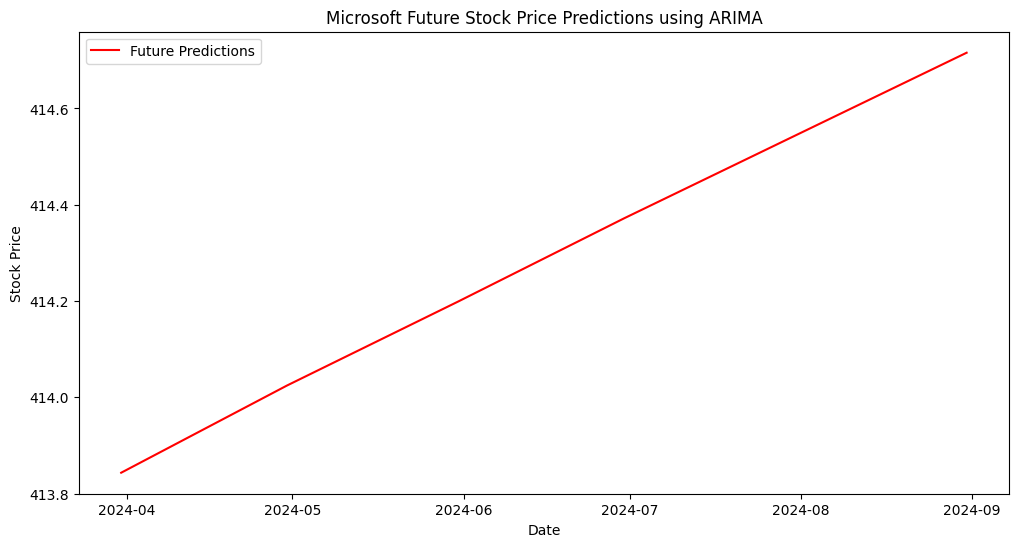

/var/folders/w2/vspf2xks0vj7x2vwsrfjnszh0000gp/T/ipykernel_94684/1675810447.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_months= pd.date_range(start=companies[name]['data'].index[-1], periods=months+1, freq='M')[1:]


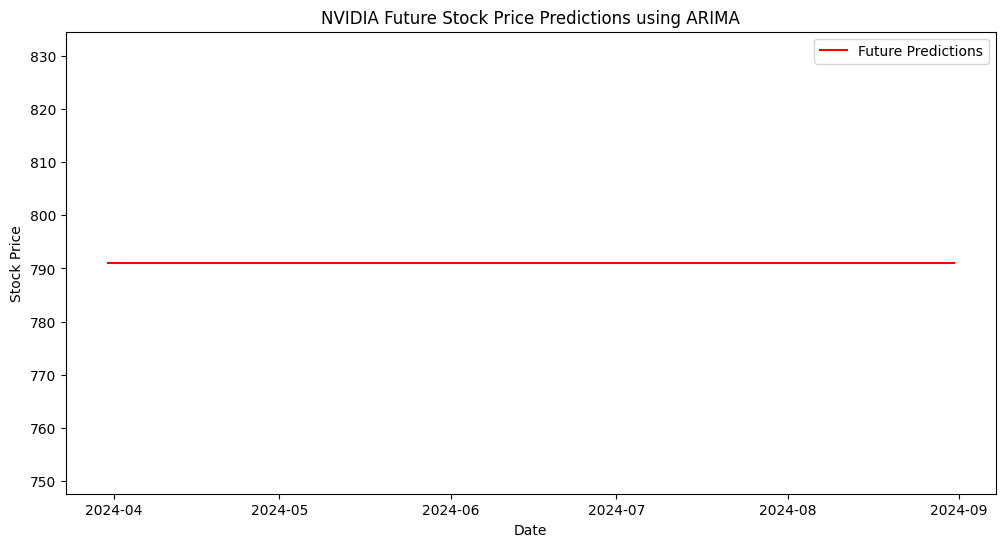

In [178]:
months = 6

for name, company in companies_history.items():
    future_predictions = []

    for month in range(months):
        yhat = future_forecast(company['history'], months=1)
        company['history'].append(yhat)
        future_predictions.append(yhat)

    future_months= pd.date_range(start=companies[name]['data'].index[-1], periods=months+1, freq='M')[1:]
    plot_future_forecast(name, future_months, future_predictions)